In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report, auc
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.utils import resample

- | PRG           | Attribute1       |  Plasma glucose level

- | PL               | Attribute 2     |   Blood Work Result-1 (mu U/ml)                                                                                                                                               
- | PR              | Attribute 3      | Blood Pressure (mmHg )    

- | SK              | Attribute 4      | Blood Work Result-2 (mm) 

- | TS             | Attribute 5      |     Blood Work Result-3 (mu U/ml)
                                                                                               
- | M11     | Attribute 6    |  Body mass index (weight in kg/(height in m))^2

- | BD2             | Attribute 7     |   Blood Work Result-4 (mu U/ml)                                                                                                                                               
- | Age              | Attribute 8      |    patients age  (years)                                                                                                                                          

- | Sepssis                 | Target           | Positive: if a patient in ICU will 
develop a sepsis , and Negative: otherwise |


# First, open the csv file 

In [2]:
test = pd.read_csv('Paitients_Files_Test.csv')
train = pd.read_csv('Paitients_Files_Train.csv')
train.head()

ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive

In [3]:
print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")                 

Train data shape: (599, 11)
Test data shape: (169, 10)


# EDA - Exploratory Data Analysis and data preprocessing 

In [4]:
train.describe().transpose()

count        mean         std     min     25%      50%      75%  \
PRG        599.0    3.824708    3.362839   0.000   1.000    3.000    6.000   
PL         599.0  120.153589   32.682364   0.000  99.000  116.000  140.000   
PR         599.0   68.732888   19.335675   0.000  64.000   70.000   80.000   
SK         599.0   20.562604   16.017622   0.000   0.000   23.000   32.000   
TS         599.0   79.460768  116.576176   0.000   0.000   36.000  123.500   
M11        599.0   31.920033    8.008227   0.000  27.100   32.000   36.550   
BD2        599.0    0.481187    0.337552   0.078   0.248    0.383    0.647   
Age        599.0   33.290484   11.828446  21.000  24.000   29.000   40.000   
Insurance  599.0    0.686144    0.464447   0.000   0.000    1.000    1.000   

              max  
PRG         17.00  
PL         198.00  
PR         122.00  
SK          99.00  
TS         846.00  
M11         67.10  
BD2          2.42  
Age         81.00  
Insurance    1.00

In [5]:
print(train.info(),'\n')
print(train.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB
None 

ID            object
PRG            int64
PL             int64
PR             int64
SK             int64
TS             int64
M11          float64
BD2          float64
Age            int64
Insurance      int64
Sepssis       object
dtype: object


In [6]:
train.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [7]:
#rename sepssis
train.rename(columns={'Sepssis':'Sepsis'}, inplace=True)

In [8]:
X= train.iloc[:,1:-1]
y = train.iloc[:,-1].map({'Positive':1,'Negative':0})
features = X.columns
X.shape, y.shape

((599, 9), (599,))

In [9]:
X = train.drop(['ID','Insurance','Sepsis'], axis = 1)

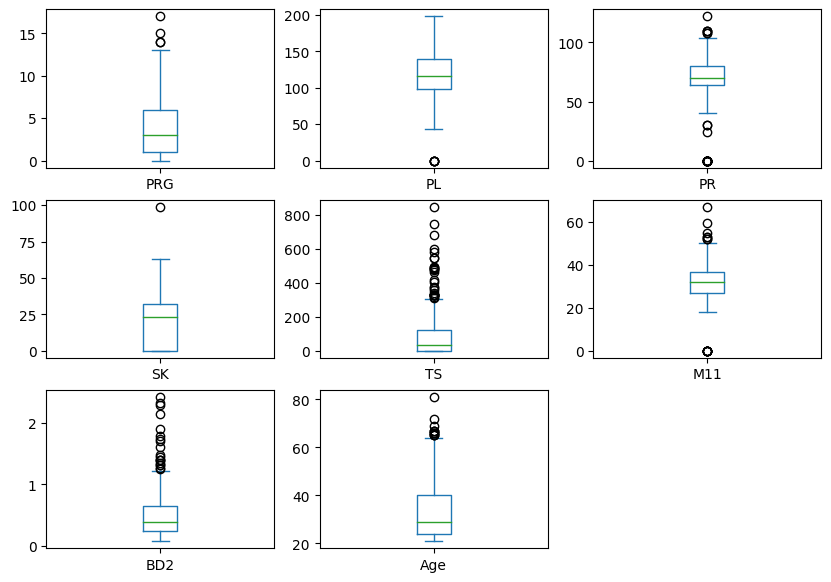

In [10]:
X.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (10, 7))
plt.show()

In [11]:
def find_outliers(data):
    # Calculate the interquartile range (IQR)
    for col in list(data.columns):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count the number of outliers
        num_outliers = len(data[(data[col] < lower_bound) | (data[col] > upper_bound)])
        print(f"{col} has {num_outliers} outliers")
    
find_outliers(X)

PRG has 4 outliers
PL has 5 outliers
PR has 37 outliers
SK has 1 outliers
TS has 28 outliers
M11 has 16 outliers
BD2 has 19 outliers
Age has 12 outliers


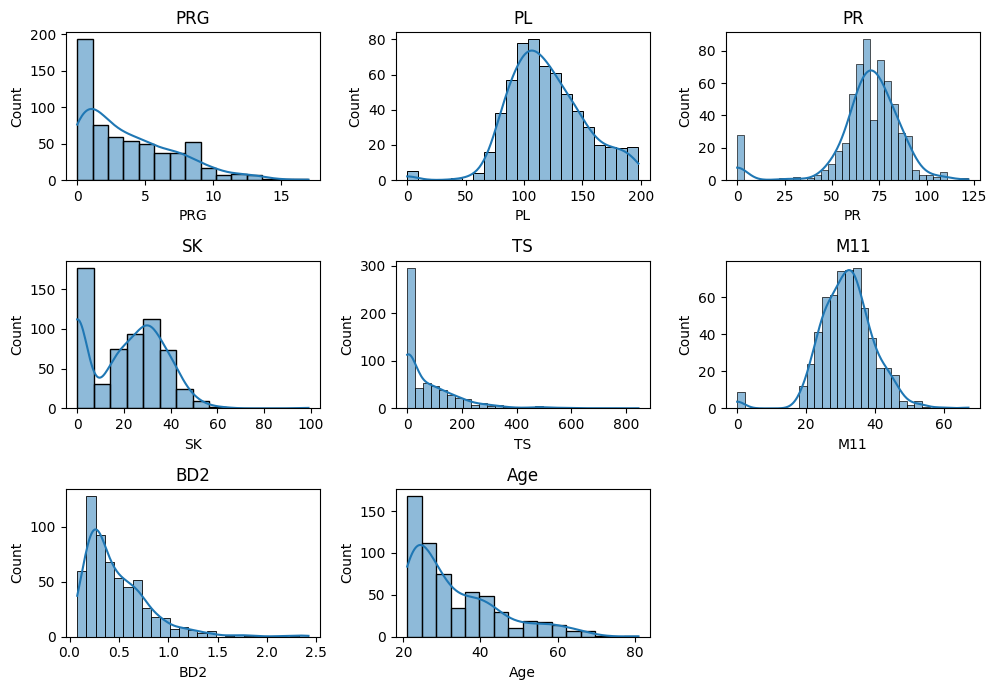

In [12]:
#check the distribution  of the data
def check_distribution(data):
    plt.figure(figsize=(10, 7))
    for i, col in enumerate(data.columns):
        plt.subplot(3, 3, i+1)
        sns.histplot(data[col], kde=True)
        plt.title(col)
    plt.tight_layout()
    plt.show()
check_distribution(X)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


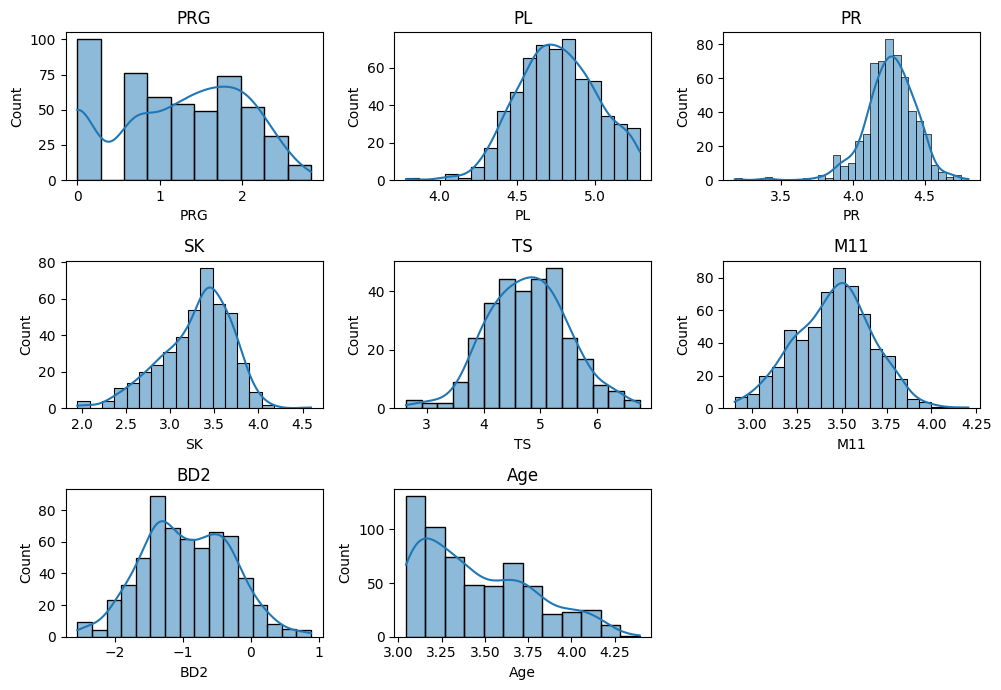

In [13]:
def re_distribute(data):
    for col in list(data.columns):
        data[col] = np.log(data[col])
    return data
re_distribute(X)
check_distribution(X)

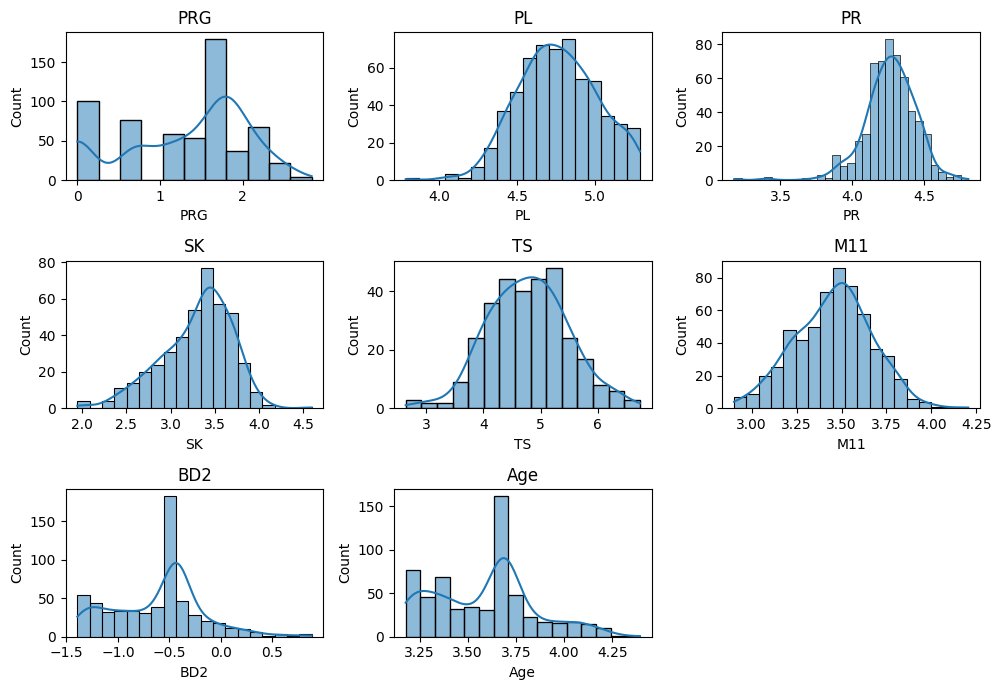

In [14]:
X["PRG"] = np.where(X["PRG"] < X["PRG"].quantile(0.25), X["PRG"].quantile(0.75), X["PRG"])
X["Age"] = np.where(X["Age"] < X["Age"].quantile(0.25), X["Age"].quantile(0.75), X["Age"])
X["BD2"] = np.where(X["BD2"] < X["BD2"].quantile(0.25), X["BD2"].quantile(0.75), X["BD2"])
check_distribution(X)

C:\Users\Admin\AppData\Local\Temp\ipykernel_25564\86519417.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = train.corr()


Text(0.5, 1.0, 'Correlation Matrix of Data')

<Figure size 900x800 with 0 Axes>

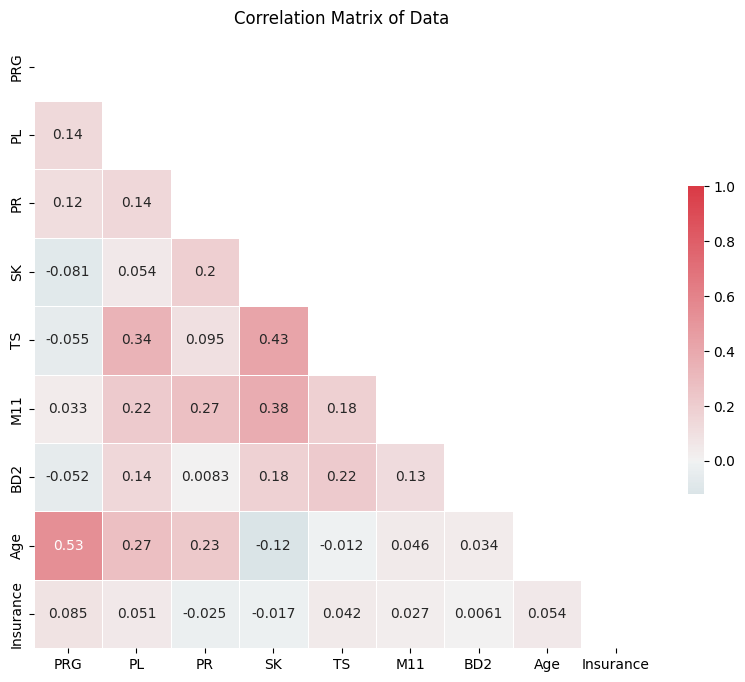

In [15]:
plt.figure(figsize= (9,8))
cor = train.corr() 
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(cor, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .5}, annot = True)
ax.set_title('Correlation Matrix of Data')

In [16]:
# Concatenate X and y into a single DataFrame
reTrain = pd.concat([X, y], axis=1)

# Separate the minority and majority classes
major = reTrain[reTrain['Sepsis'] == 0]
minor = reTrain[reTrain['Sepsis'] == 1]

# Upsample the minority class
upsample = resample(minor,
                    replace=True,     # sample with replacement
                    n_samples=391)    # to match minority class count

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([major, upsample])

# Separate the feature matrix X and target variable y
upsampled_X = upsampled_data.iloc[:, :-1]
upsampled_y = upsampled_data.iloc[:, -1]
print("New shape of the dataset:", upsampled_X.shape, upsampled_y.shape)
upsampled_y.value_counts()

New shape of the dataset: (782, 8) (782,)


0    391
1    391
Name: Sepsis, dtype: int64

In [17]:
#replace inf values with nan
upsampled_X.replace([np.inf, -np.inf], np.nan, inplace=True)
#reoplace Nan by mean + 2std
upsampled_X.fillna(upsampled_X.mean(), inplace=True)

In [18]:
cleaned_train = pd.concat([upsampled_X, upsampled_y], axis=1)
cleaned_train.to_csv('cleaned_train.csv')

In [19]:
#split the data into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(upsampled_X, upsampled_y, test_size = 0.2, random_state = 42)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((625, 8), (157, 8), (625,), (157,))

Logistic Regression Results:
Training Accuracy: 0.72
Testing Accuracy: 0.7261146496815286
Training Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72       308
           1       0.72      0.73      0.72       317

    accuracy                           0.72       625
   macro avg       0.72      0.72      0.72       625
weighted avg       0.72      0.72      0.72       625

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75        83
           1       0.72      0.68      0.70        74

    accuracy                           0.73       157
   macro avg       0.73      0.72      0.72       157
weighted avg       0.73      0.73      0.73       157

Training Confusion Matrix:
 [[220  88]
 [ 87 230]]
Testing Confusion Matrix:
 [[64 19]
 [24 50]]
-----------------------------
Decision Tree Results:
Training Accuracy: 1.0
Testing Accuracy: 

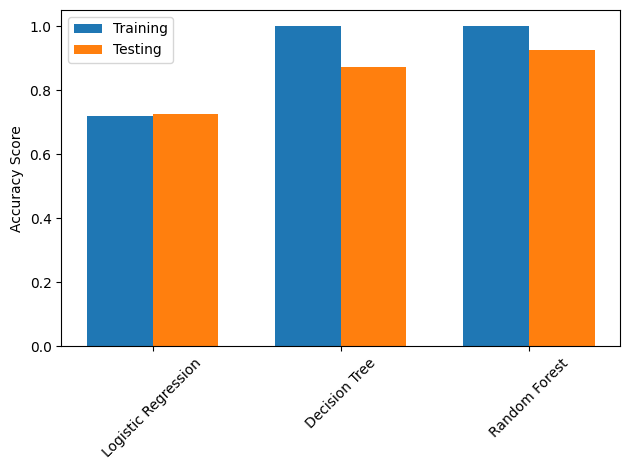

In [25]:
# define a function to train and evaluate the models
def train_and_evaluate(model):
    # fit the model on the training data then make predictions
    model.fit(Xtrain, ytrain)
    
    train_preds = model.predict(Xtrain)
    test_preds = model.predict(Xtest)
    
    # calculate accuracy scores
    train_acc = accuracy_score(ytrain, train_preds)
    test_acc = accuracy_score(ytest, test_preds)
    # generate classification reports and confusion matrices
    train_report = classification_report(ytrain, train_preds)
    test_report = classification_report(ytest, test_preds)
    train_confusion = confusion_matrix(ytrain, train_preds)
    test_confusion = confusion_matrix(ytest, test_preds)
    
    return train_acc, test_acc, train_report, test_report, train_confusion, test_confusion
    
# define the models
lr = LogisticRegression(max_iter=1000)
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()


# train and evaluate each model
lr_train_acc, lr_test_acc, lr_train_report, lr_test_report, lr_train_cm, lr_test_cm = train_and_evaluate(lr)
dt_train_acc, dt_test_acc, dt_train_report, dt_test_report, dt_train_cm, dt_test_cm = train_and_evaluate(tree)
rf_train_acc, rf_test_acc, rf_train_report, rf_test_report, rf_train_cm, rf_test_cm = train_and_evaluate(rf)


# print the results for each model
print("Logistic Regression Results:")
print("Training Accuracy:", lr_train_acc)
print("Testing Accuracy:", lr_test_acc)
print("Training Classification Report:\n", lr_train_report)
print("Testing Classification Report:\n", lr_test_report)
print("Training Confusion Matrix:\n", lr_train_cm)
print("Testing Confusion Matrix:\n", lr_test_cm)
print("-----------------------------")

# print("K-Nearest Neighbors Results:")
# print("Training Accuracy:", knn_train_acc)
# print("Testing Accuracy:", knn_test_acc)
# print("Training Classification Report:\n", knn_train_report)
# print("Testing Classification Report:\n", knn_test_report)
# print("Training Confusion Matrix:\n", knn_train_cm)
# print("Testing Confusion Matrix:\n", knn_test_cm)
# print("-----------------------------")

# print("Support Vector Machine Results:")
# print("Training Accuracy:", svc_train_acc)
# print("Testing Accuracy:", svc_test_acc)
# print("Training Classification Report:\n", svc_train_report)
# print("Testing Classification Report:\n", svc_test_report)
# print("Training Confusion Matrix:\n", svc_train_cm)
# print("Testing Confusion Matrix:\n", svc_test_cm)
# print("-----------------------------")

print("Decision Tree Results:")
print("Training Accuracy:", dt_train_acc)
print("Testing Accuracy:", dt_test_acc)
print("Training Classification Report:\n", dt_train_report)
print("Testing Classification Report:\n", dt_test_report)
print("Training Confusion Matrix:\n", dt_train_cm)
print("Testing Confusion Matrix:\n", dt_test_cm)
print("-----------------------------")

print("Random Forest Results:")
print("Training Accuracy:", rf_train_acc)
print("Testing Accuracy:", rf_test_acc)
print("Training Classification Report:\n", rf_train_report)
print("Testing Classification Report:\n", rf_test_report)
print("Training Confusion Matrix:\n", rf_train_cm)
print("Testing Confusion Matrix:\n", rf_test_cm)
print("-----------------------------")

# plot a chart to show the differences between the models
# labels = ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest']
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest']
# train_accs = [lr_train_acc, knn_train_acc, svc_train_acc, dt_train_acc, rf_train_acc]
# test_accs = [lr_test_acc, knn_test_acc, svc_test_acc, dt_test_acc, rf_test_acc]
train_acc = [lr_train_acc, dt_train_acc, rf_train_acc]
test_acc = [lr_test_acc, dt_test_acc, rf_test_acc]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_acc, width, label='Training')
rects2 = ax.bar(x + width/2, test_acc, width, label='Testing')

ax.set_ylabel('Accuracy Score')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


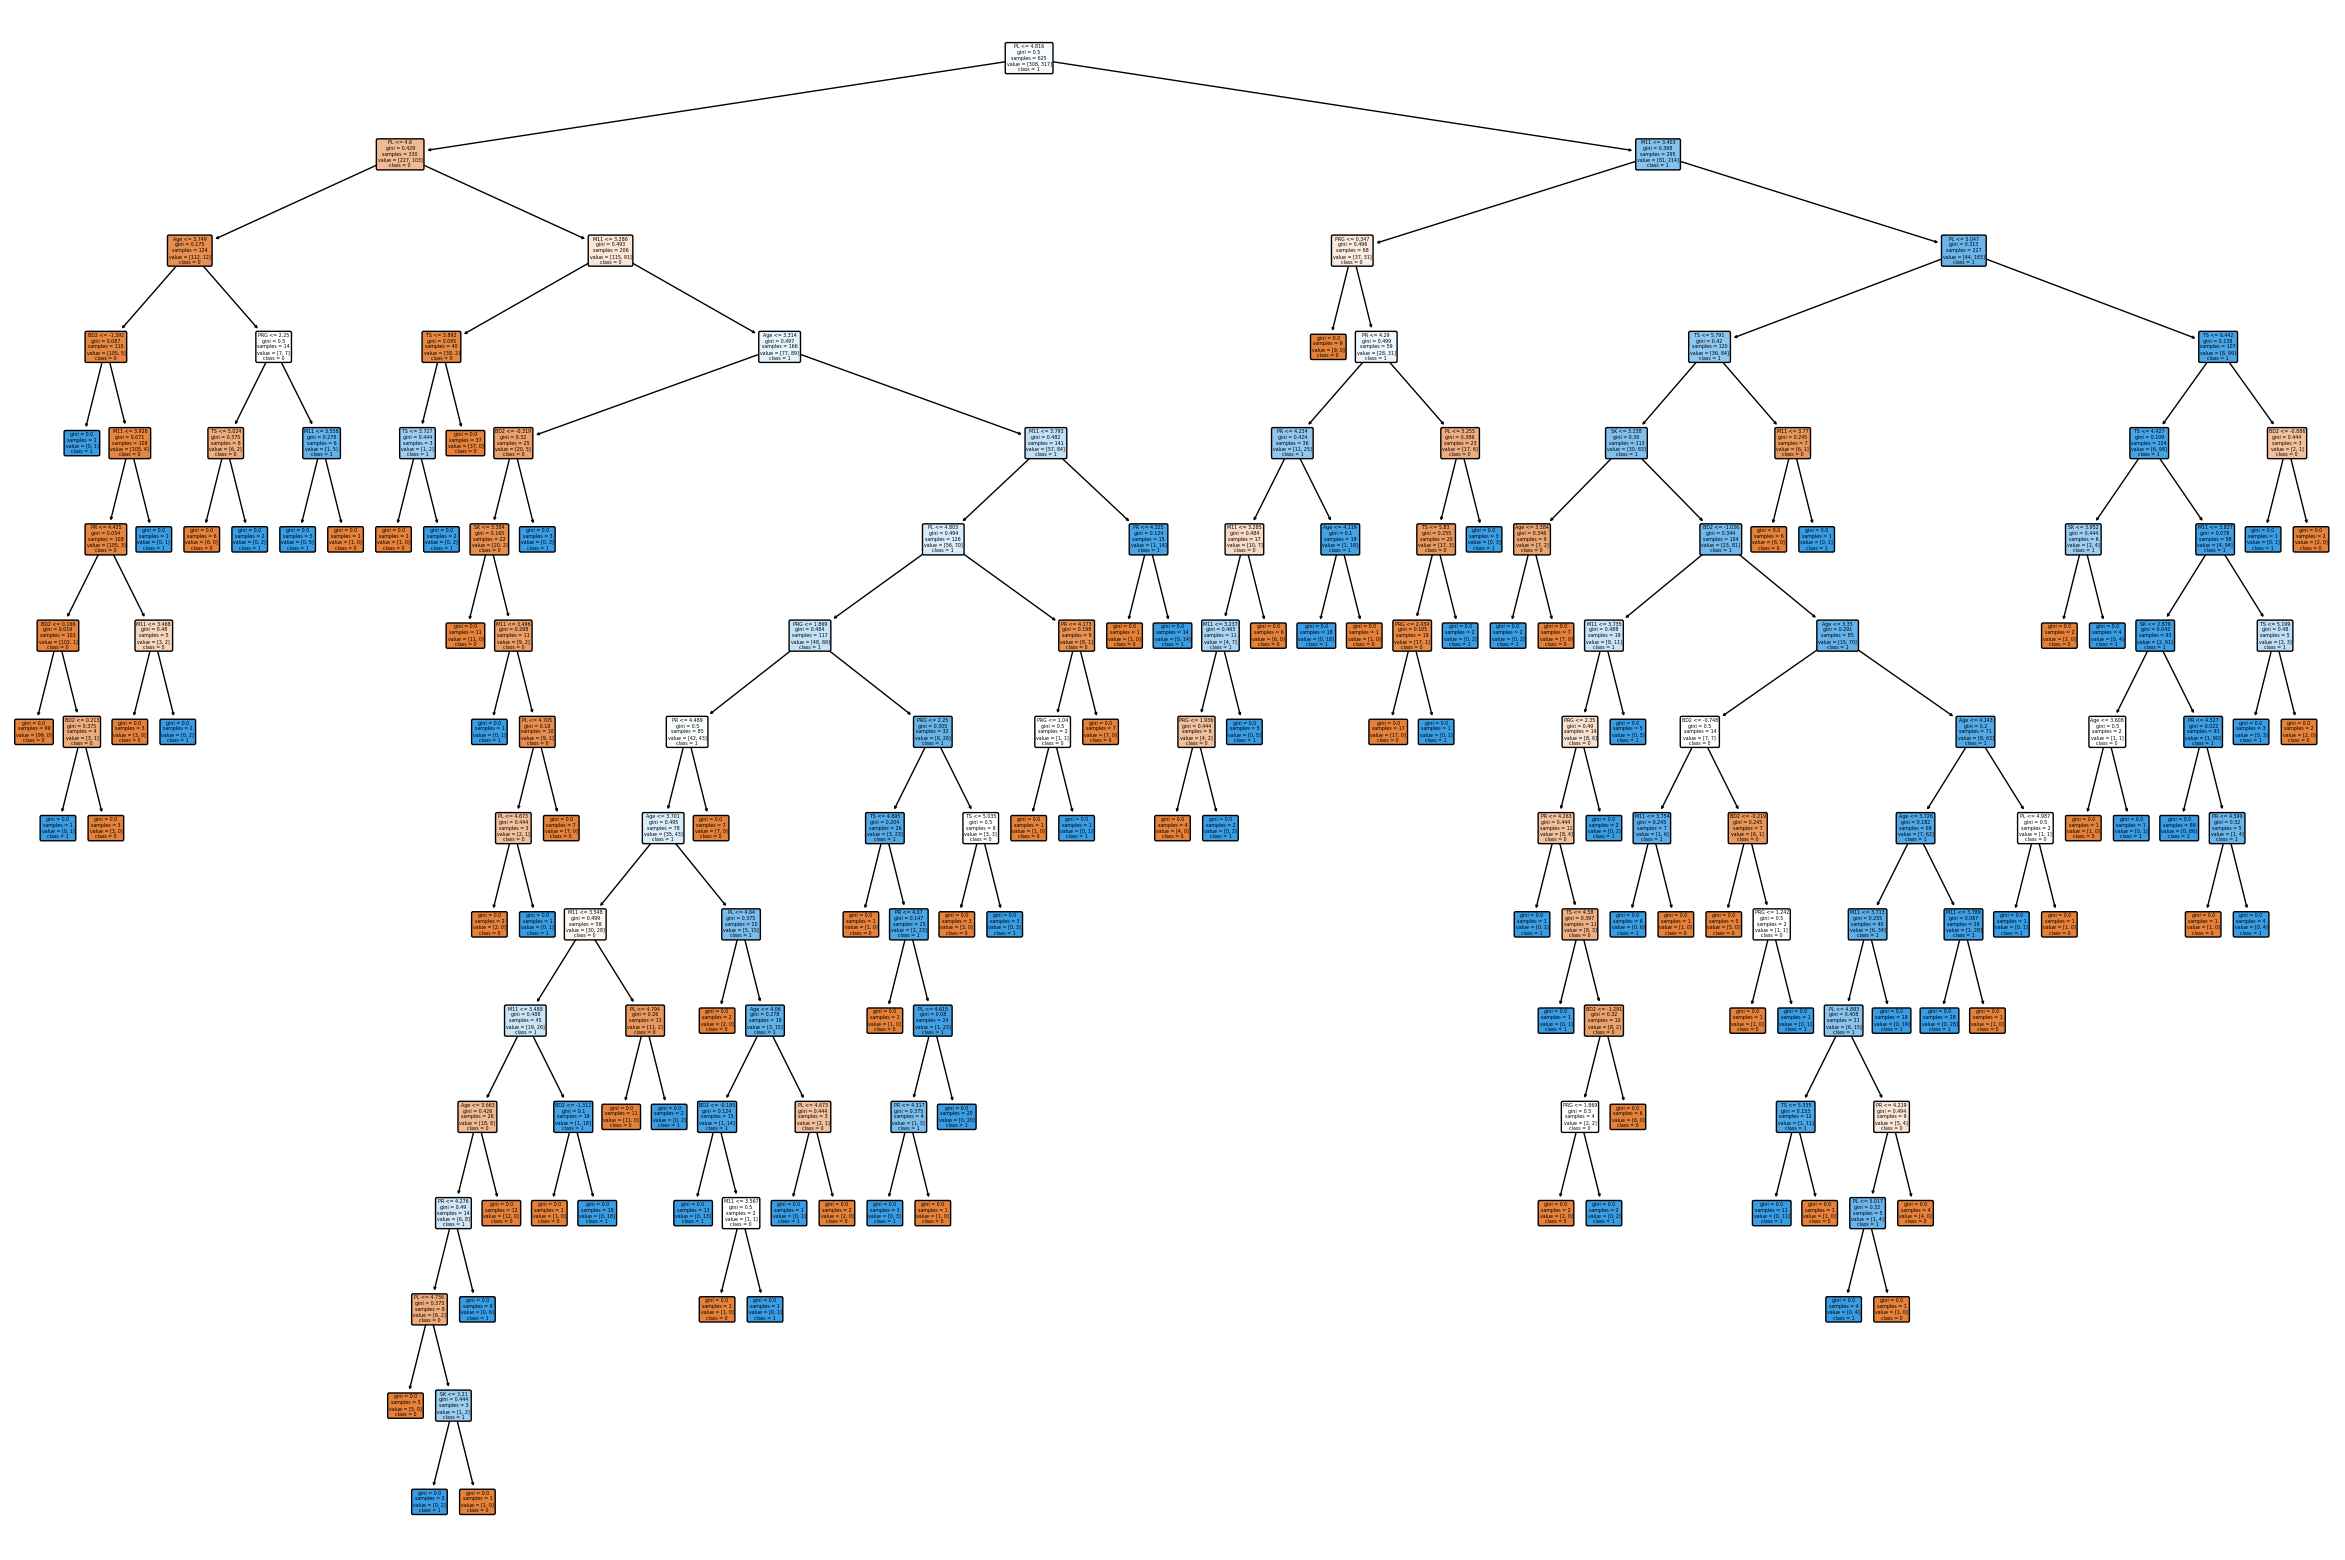

In [27]:
tree = DecisionTreeClassifier()
tree.fit(Xtrain, ytrain)
ytrainPred = tree.predict(Xtrain)
ytestPred = tree.predict(Xtest)
plt.figure(figsize=(30,20))
plot_tree(tree, filled=True, rounded=True, class_names=['0','1'], feature_names=upsampled_X.columns)
plt.show()

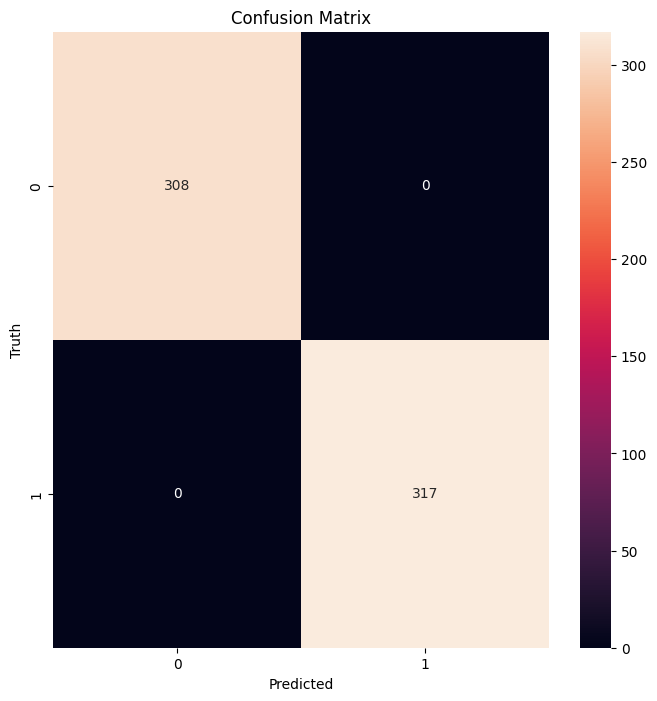

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       308
           1       1.00      1.00      1.00       317

    accuracy                           1.00       625
   macro avg       1.00      1.00      1.00       625
weighted avg       1.00      1.00      1.00       625



In [28]:
def plotMaxtrix(ytrainPred, ytrain, dom):
    cm = confusion_matrix(ytrain, ytrainPred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    print(dom)
    print(classification_report(ytrain, ytrainPred))
    
plotMaxtrix(ytrainPred, ytrain, 'Train')

In [29]:
# grid search CV to find the best parameters
params = {
    "max_depth": range(1,12),
    "min_samples_split": range(2,20),
    "min_samples_leaf": range(1,20),
    "criterion": ("gini", "entropy", "log_loss"),
    "splitter": ("best", "random"),
}
tree2 = DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree2, param_grid=params)
grid.fit(Xtrain, ytrain)
print("best params:", grid.best_params_)

best params: {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [30]:
#function to find max_leaf_node 
def find_max_leaf_node(Xtrain, ytrain):
    max_leaf_nodes = []
    for i in range(2, 100):
        tree = DecisionTreeClassifier(max_leaf_nodes=i, random_state=0)
        tree.fit(Xtrain, ytrain)
        max_leaf_nodes.append(tree.tree_.node_count)
    return max_leaf_nodes
max_leaf_node = find_max_leaf_node(Xtrain, ytrain)
print(max(max_leaf_node))

191


In [31]:
model = grid.best_estimator_
print(grid.best_params_)
model.fit(Xtrain, ytrain)
print("train score: ", model.score(Xtrain, ytrain))
print("test score: ", model.score(Xtest, ytest))

{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
train score:  0.9712
test score:  0.8152866242038217


In [32]:
path = model.cost_complexity_pruning_path(Xtrain, ytrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("CCP Alphas: ", ccp_alphas)
print("Impurities: ", impurities)

clfs = []
for ccp_alpha in ccp_alphas:
    tree3 = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree3.fit(Xtrain, ytrain)
    clfs.append(tree3)

CCP Alphas:  [0.         0.00066667 0.00137143 0.00142222 0.00144    0.00146909
 0.00156559 0.00158447 0.0016     0.00177778 0.00213333 0.00213333
 0.00221421 0.0024381  0.00266667 0.00271282 0.00274286 0.00274286
 0.00288    0.00295749 0.00298667 0.00302222 0.00302595 0.00303158
 0.00346034 0.00355385 0.00384962 0.00394667 0.004      0.00407273
 0.00426667 0.00476694 0.00497778 0.00503102 0.00513778 0.00541538
 0.0060313  0.00698182 0.00700895 0.00779814 0.00785904 0.00821114
 0.00918239 0.01064219 0.02054499 0.02437708 0.02947787 0.08514164]
Impurities:  [0.0415191  0.04218577 0.04492862 0.04777307 0.05065307 0.05359125
 0.05985362 0.06302255 0.06462255 0.06995588 0.07208921 0.07422255
 0.0852936  0.08773169 0.09039836 0.095824   0.09856686 0.10130971
 0.10418971 0.11601966 0.11900632 0.12202854 0.13413234 0.13716392
 0.14062426 0.14773195 0.15158158 0.15552824 0.15952824 0.1676737
 0.17620703 0.19050785 0.19548562 0.20051664 0.20565442 0.2110698
 0.21710111 0.22408293 0.2731456  0.2

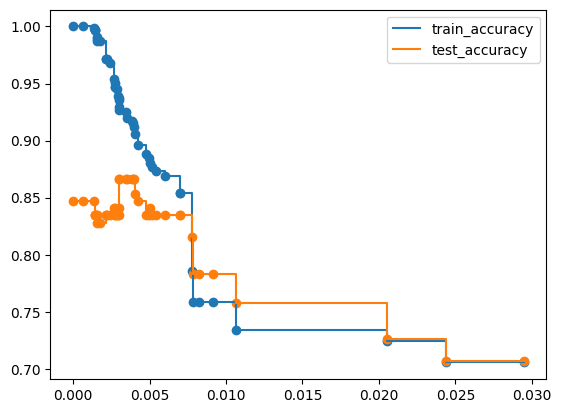

In [36]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(Xtrain)
    y_test_pred = c.predict(Xtest)
    train_acc.append(accuracy_score(y_train_pred,ytrain))
    test_acc.append(accuracy_score(y_test_pred,ytest))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.show()

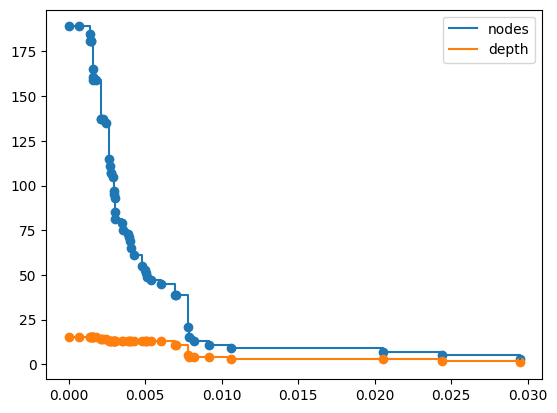

In [34]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

  [0.         0.00066667 0.00137143 0.00142222 0.00144    0.00146909
 0.00156559 0.00158447 0.0016     0.00177778 0.00213333 0.00213333
 0.00221421 0.0024381  0.00266667 0.00271282 0.00274286 0.00274286
 0.00288    0.00295749 0.00298667 0.00302222 0.00302595 0.00303158
 0.00346034 0.00355385 0.00384962 0.00394667 0.004      0.00407273
 0.00426667 0.00476694 0.00497778 0.00503102 0.00513778 0.00541538
 0.0060313  0.00698182 0.00700895 0.00779814 0.00785904 0.00821114
 0.00918239 0.01064219 0.02054499 0.02437708 0.02947787 0.08514164]

 {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best', max_leaf_ndoes = 191
}


In [99]:
LastTree = DecisionTreeClassifier(ccp_alpha=0.00295749,          
                                  max_depth=11, 
                                  criterion='gini',
                                  splitter='best',
                                  min_samples_leaf= 1,
                                  min_samples_split= 2,
                                  max_leaf_nodes=191,
                                  )

LastTree.fit(Xtrain, ytrain)
LasTrainPred= LastTree.predict(Xtrain)
LastTestPred= LastTree.predict(Xtest)
print("Train report:\n", classification_report(ytrain, LasTrainPred))
print("Accuracy score train: ", accuracy_score(ytrain, LasTrainPred))
print("Test report:\n", classification_report(ytest, LastTestPred))
print("Accuracy score test: ", accuracy_score(ytest, LastTestPred))

Train report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       308
           1       0.93      0.93      0.93       317

    accuracy                           0.93       625
   macro avg       0.93      0.93      0.93       625
weighted avg       0.93      0.93      0.93       625

Accuracy score train:  0.928
Test report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        83
           1       0.83      0.86      0.85        74

    accuracy                           0.85       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.85      0.85      0.85       157

Accuracy score test:  0.8535031847133758


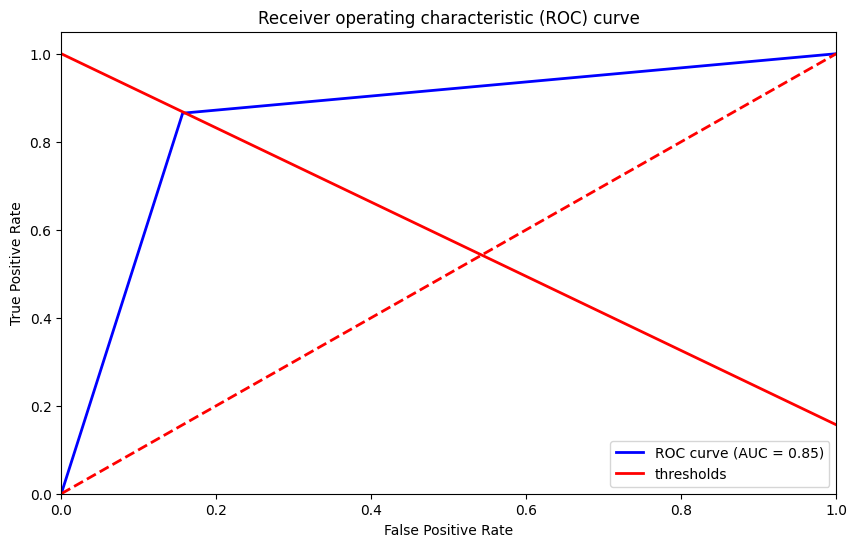

AUC:  0.8541191794203843


In [100]:
yScores = LastTree.predict_proba(Xtest)[:,1]
def plot_ROC(yTrue, yScores):
    # Calculate the false positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(yTrue, yScores)
    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot(thresholds, fpr, color='r', lw=2, label='thresholds')
    plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: ", roc_auc)
plot_ROC(ytest, LastTestPred)

In [103]:
#random Forest
rf = RandomForestClassifier(ccp_alpha=0.00295749,          
                                  max_depth=11, 
                                  criterion='gini',
                                  min_samples_leaf= 1,
                                  min_samples_split= 2,
                                  max_leaf_nodes=191,
                                  )
rf.fit(Xtrain, ytrain)
rf_train_pred= rf.predict(Xtrain)
rf_test_pred= rf.predict(Xtest)
print("report on train set:\n",classification_report(ytrain, rf_train_pred))
print("Accuracy score train: ", accuracy_score(ytrain, rf_train_pred))
print("report on test set:\n",classification_report(ytest, rf_test_pred))
print("Accuracy score test: ", accuracy_score(ytest, rf_test_pred))

report on train set:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       308
           1       0.95      0.97      0.96       317

    accuracy                           0.96       625
   macro avg       0.96      0.96      0.96       625
weighted avg       0.96      0.96      0.96       625

Accuracy score train:  0.9584
report on test set:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91        83
           1       0.86      0.95      0.90        74

    accuracy                           0.90       157
   macro avg       0.91      0.91      0.90       157
weighted avg       0.91      0.90      0.90       157

Accuracy score test:  0.9044585987261147


In [107]:
bipdata = test 
bipdata.head()
bipdata.shape

(169, 10)

In [108]:
bipdata = test.drop(['ID', "Insurance"], axis= 1)

In [109]:
ybip = rf.predict(bipdata)  

In [110]:
bipdata['Sepsis'] = ybip
bipdata.head()

PRG   PL  PR  SK   TS   M11    BD2  Age  Sepsis
0    1  109  38  18  120  23.1  0.407   26       0
1    1  108  88  19    0  27.1  0.400   24       1
2    6   96   0   0    0  23.7  0.190   28       1
3    1  124  74  36    0  27.8  0.100   30       1
4    7  150  78  29  126  35.2  0.692   54       1

In [112]:
predict = pd.DataFrame ({
    "ID": test["ID"],
    "Sepsis": bipdata["Sepsis"].map({0: "Negative", 1: "Positive"})
})
finalPred = predict.to_csv("s3877256_prediction.csv", index=False)
